# Exploration 8. 뉴스 요약봇 만들기 👩🏻‍🚀 
### [네이버 요약봇]
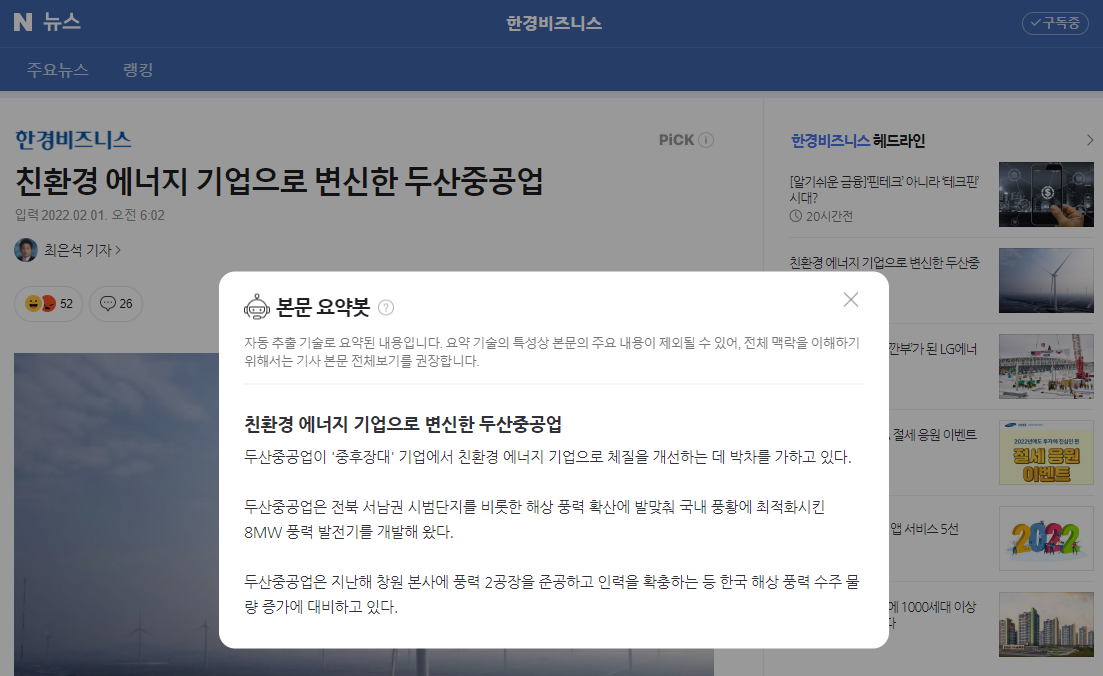

#### 🌷 추출적 요약(Extractive Summarization): 원문에서 문장들을 추출해서 요약하는 방식  
- 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용  
-어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제  


#### 🌷 추상적 요약(Abstractive Summarization):  원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것  
- 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역   
-RNN으로 추상적 요약 방식을 구현할 수 있으나, 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 "장기 의존성(long term dependencies) 문제"   
-seq2seq(sequence-to-sequence): 구글이 메일서비스에 적용한 자동 회신(Smart Reply) 기능을 만든 것과 비슷한 딥러닝 기법이기도 한 인코더와 디코더의 구조로 구성된 딥러닝 아키텍처

## 🤖  seq2seq 모델 🤖
> **두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델**
>1. 첫 번째 RNN인 인코더에 원문 입력
2. 고정된 벡터로 변환. 이때, 벡터를 문맥 정보를 가지고 있는 벡터라고 하여 **컨텍스트 벡터(context vector)**
3. 두 번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약 문장을 완성
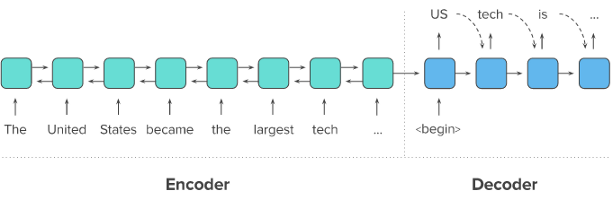

#### 🌷 LSTM과 컨텍스트 벡터
> **seq2seq를 구현 시, 인코더/디코더로 바닐라 RNN이 아니라 LSTM을 사용**
>- LSTM이 바닐라 RNN과 다른 점은 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점. 
> - 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두 개의 값 모두 존재해야 함. 
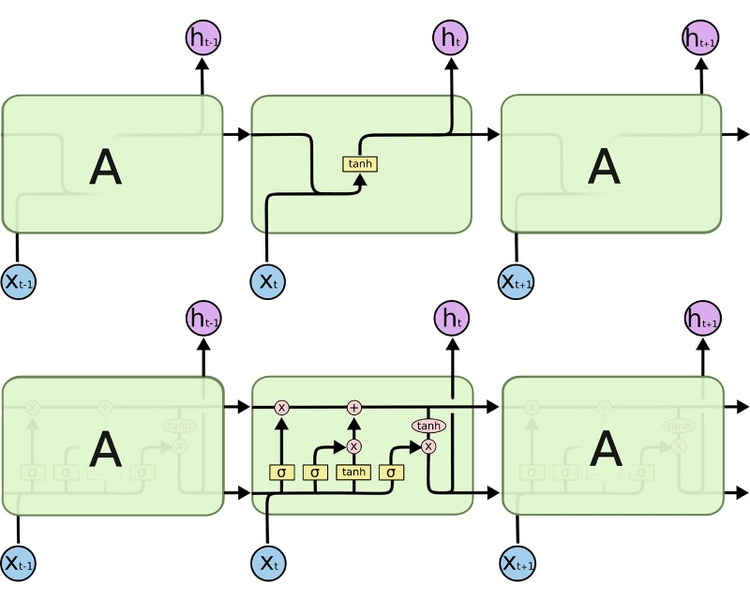

#### 🌷 시작 토큰(SOS)과 종료 토큰(EOS) 넣어주는 전처리 필요   
#### 🌷 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기
> 기존의 컨텍스트 벡터보다 인코더의 정보를 적극적으로 활용하여 성능을 끌어올리는 어텐션 메커니즘

### 🤖 정리 🤖
1. seq2seq를 사용합니다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

# 🌴 Practice 🌴
### 1. 데이터 준비하기
> Kaggle에서 제공된 아마존 리뷰 데이터셋

#### - NLTK 패키지에서 불용어 사전을 다운로드하고, 데이터 전처리를 위한 나머지 패키지도 함께 불러오기

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

#### - 링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플 중 시간상 10만 개의 샘플만 사용하기

In [ ]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

#### - 불러온 샘플 데이터 출력해보기

In [ ]:
data.head()

#### - 훈련에 사용할 Summary 열과 Text 열만 별도로 저장 후 출력해보기

In [ ]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

> 🔥 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 것임

## 2. 데이터 전처리하기 
:  null 데이터, 중복 데이터 솎아내기
## (1) 데이터 정리하기
#### - 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [ ]:
# 데이터의 중복 샘플 유무를 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

🌷 `drop_duplicates()`를 사용하여 손쉽게 중복 샘플을 제거

In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

🌷  `.isnull().sum()`을 사용하여 데이터프레임에 Null 값이 있는지 확인

In [ ]:
print(data.isnull().sum())

🌷` dropna()` 함수를 사용하여 데이터프레임에서 Null을 제거

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

#### - 텍스트 정규화와 불용어 제거
>**🤖 텍스트 정규화(text normalization) 🤖**  
> 예를 들어서, it'll은 it will과 같고, mustn't과 must not과 같은 표현들을 기계 학습 전에 미리 같은 표현으로 통일시켜주어 기계의 연산량을 줄임

🌷 텍스트 정규화를 위한 사전(dictionary) 구성하기  
참고 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

🌷 NLTK에서 제공하는 불용어 리스트를 참조

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

🌷 샘플에서 불용어 제거
- Text 전처리 시에서만 NLTK를 이용해 불용어를 제거
- Summary에는 Abstractive한 문장 요약 결과문이 자연스러운 문장이 되기 위해 불용어 남겨두기 
> 함수의 인자로 remove_stopwords를 추가하고, if문을 추가

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary) - 자연스러운 문장 위해서 !! 
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

🌷 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수 호출

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

🌷 훈련 데이터 전체에 대해서 전처리를 수행
> Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행 필요

## ⚡️⚡️ 아래 두 블록의 코드 실행 오래 걸림 (10분 정도 소요) ⚡️⚡️

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

In [ ]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))  # False: 불용어 제거를 수행하지 않는다는 의미

print("Summary 전처리 후 결과: ", clean_summary[:5])

🌷 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보기
>  정제 과정에서 문장의 모든 단어가 사라지는 경우, 샘플 자체가 빈 값을 가지게 됨

In [ ]:
# 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)  # 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체
print('=3')

🌷`.isnull().sum()`을 사용해서 Null 값이 생겼는지 확인

In [ ]:
data.isnull().sum()

🌷 Summary 열에서 70개의 Null 값 샘플 제거

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

## (2) 훈련데이터와 테스트데이터 나누기
🌷 훈련 데이터와 테스트 데이터를 분리하는 방법
- 분리 패키지를 사용하는 방법
- 직접 코딩을 통해서 분리하는 방법

#### - 필요 없는 단어를 모두 솎아낸 후, 훈련에 사용할 샘플의 최대 길이를 정해주기

🌷 Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화하기

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

🌷 위 시각화된 데이터를 참고하여 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하기

In [ ]:
text_max_len = 50
summary_max_len = 8
print('=3')

#### - 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하기
🌷  훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들기

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

🌷 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 보기

In [ ]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

>### ☂️ 결과 ☂️
각각 50과 8로 패딩을 하게 되면,  
해당 길이보다 긴 샘플들은 내용이 잘리게 되는데,   
Text 열의 경우에는 약 23%의 샘플들이 내용이 망가진다

🌷 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터 정제하기

In [ ]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

#### - 시작 토큰과 종료 토큰 추가하기

- 시작 토큰: `sostoken`
- 종료 토큰: `eostoken`
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장: `decoder_input`
- 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장: `decoder_target`
    
🌷 두 개의 문장 모두 Summary 열로부터 만들기

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

🌷 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [ ]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

🌷 encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어 주기 

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

🌷 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주기 
> ➜ 잘 섞인 샘플이 된다. 

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#### - 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
🌷 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해주기

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

🌷 테스트 데이터의 개수를 이용해 전체 데이터를 양분하기
- 훈련 데이터 52,655개
- 테스트 데이터 13,163개

In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

## (3) 정수 인코딩
### 단어 집합(vocabulary) 만들기 및 정수 인코딩
🌷 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 함.
- 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합 만들기.
- Keras의 토크나이저를 사용하여 입력된 훈련 데이터로부터 단어 집합 만들기

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

🌷 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장됨
- 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외

#### - 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인  
`src_tokenizer.word_counts.items()`에 저장되어 있는 단어와 각 단어의 등장 빈도수를 통해 통계적인 정보 얻기

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

> 🗼 threshold 값인 7회 미만인 단어들은 단어 집합에서 무려 70% 이상을 차지함.  
>🗼 하지만, 실제 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%

#### - 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하기
🌷 단어 집합의 크기 `num_words`를 8,000으로 제한

In [ ]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

🌷 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행하기
- `texts_to_sequences()` 사용
- 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

#### - Summary 데이터에 대해서도 동일한 작업을 수행하기
🌷 케라스의 토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수 계산하기

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

>🗼 단어 집합이 `tar_tokenizer.word_index`에 생성되는 동시에 각 단어에 고유한 정수가 부여됨  
  🗼 `tar_tokenizer.word_counts.items()` 단어와 각 단어의 등장 빈도수가 저장됨  
  🗼 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인  

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

🌷 단어 집합의 크기로 제한하여 등장 빈도가 5회 이하인 단어들 모두 제거하기
- 단어 집합: 약 77%
- 실제 훈련 데이터: 5.87%

In [ ]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

#### - 요약문에서 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장한 후 삭제
🌷 요약문에서 길이가 0이 된 샘플들의 인덱스 없음
- `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이므로
- 길이가 0이 된 요약문의 실제 길이는 1로 나옴

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

#### - 패딩하기

🌷 텍스트 시퀀스를 정수 시퀀스로 변환 후, 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 필요
🌷 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이 맞추기

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

## 3.  seq2seq 모델 설계하기
#### -  함수형 API를 이용해서 인코더를 설계하기

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128  # 임베딩 벡터의 차원
hidden_size = 256  # LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 🌴 주요 개념 🌴
#### 🤖  `hidden state`
- LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
- LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수
- 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다 !!
- LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용 ➜ regularization 해주는 효과, 과적합 방지
    > - 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해줌  
    > - recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식(즉, time step의 입력을 랜덤으로 생략)
    
    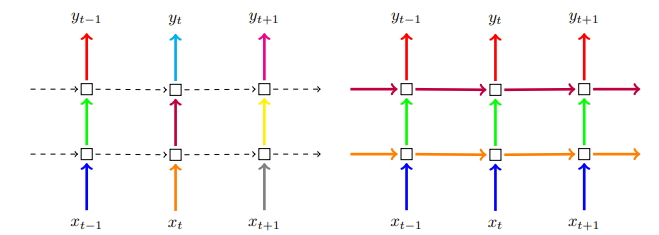
> 색이 있는 화살표: dropout  
> 색이 다른 화살표: 다른 dropout mask 사용
#### 🤖  우리가 현재 사용한 LSTM은 dropout과 recurrent dropout을 모두 사용 = `Variational Dropout`라고 함

### 🧨 recurrent dropout 사용 시 WARNING 뜨는 이유는 ? 
 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다... 대신 generic GPU kernel 사용 ??

#### - 디코더 설계하기
- 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일. 
- 하지만 LSTM의 입력을 정의할 때, `initial_state`의 인자값으로 인코더의 `hidden state`와 `cell stat`e의 값을 넣어줘야 함.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### - 디코더의 출력층을 설계하기

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

#### 🌷 디코더의 출력층 🌷 
-  Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 함
- Dense의 인자로 tar_vocab을 줌
- 활성화 함수로 소프트맥스 사용
--- 

## 🤖 어텐션 메커니즘 🤖
- 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법
-  TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배우기
-  `Bahdanau 스타일`의 어텐션 사용

#### - 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층 수정하기
🌷   인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,   
🌷  어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하는 코드


In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

## 4. 모델 훈련하기

#### 🌷 optimizer로 RMS Prop 사용
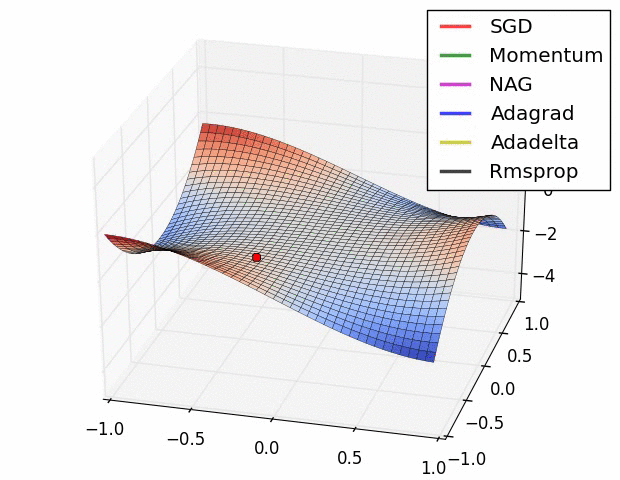

#### 🌷 `EarlyStopping(조기 종료)`: 특정 조건이 충족되면 훈련을 멈추는 역할
- `val_loss`(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
-  epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈춘다.

#### - 설계한 모델을 가지고 훈련 진행하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

#### -  훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화하기

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5. 인퍼런스 모델 구현하기
#### - 필요한 3개의 사전 미리 준비하기
🌷 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 🪄 잠깐!!
> 🌷 seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다

- 훈련 단계:디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비
-  정답 문장이 없는 인퍼런스 단계: 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함

#### -  인코더 모델과 디코더 모델을 분리해서 설계

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### - 어텐션 메커니즘을 사용하는 출력층을 설계하기

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#### - 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 6. 모델 테스트하기
🌷 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.

#### - 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만들기
>- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0 제외
>- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

#### - 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교하기

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

### 👩🏻‍🚀 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과 !!

## ⚡️⚡️ 성능 개선 방안 ⚡️⚡️
- seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정
- 빔 서치(beam search)
- 사전 훈련된 워드 임베딩(pre-trained word embedding)
- 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer) 👩🏻‍🚀

## 7. 추출적 요약 해보기
> 🌷 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약하는 방법

## 🌴 영화 매트릭스 시놉시스를 요약 실습 🌴

### (1) 패키지 설치

In [ ]:
# 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공
$ pip list | grep summa

### (2) 데이터 다운로드하기

In [ ]:
import requests
from summa.summarizer import summarize

#### - 매트릭스 시놉시스를 다운로드

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

#### - text에는 매트릭스 시놉시스가 문자열로 잘 저장되어 있는지 일부만 확인

In [ ]:
print(text[:1500])

## (3) summarize 사용하기
🌷 `summarize()`의 인자
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.  
    만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

🌷`summarize()`의 특징
> 내부적으로 문장 토큰화를 수행,,  
 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다

#### - 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여보기

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))  # 원문의 0.005%만을 출력하도록 설정

#### - 리스트로 출력 결과를 받기 
🌷 split 인자의 값 = True

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

#### - 단어의 수로 요약문의 크기를 조절하기

In [ ]:
print('Summary:')
print(summarize(text, words=50))  # 단어를 50개만 선택

--- 
# 🤹‍♀️ 프로젝트: 뉴스기사 요약봇 만들기 !!! 
> 추상적 요약과 추출적 요약

## Step 1. 데이터 수집하기

In [2]:
# 라이브러리 불러오기
import pandas as pd
import urllib.request
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

#### - 데이터 다운로드

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
45595,FIR if caste panchayats do virginity test on w...,The caste panchayats of the Kanjarbhat communi...
28859,Being 1st Satyagrahi in Emergency changed my l...,"In his blog series on the Emergency, union min..."
8271,PM Narendra Modi has 'broken' all promises: Ra...,"While campaigning in poll-bound Telangana, Con..."
27627,Double-decker bus crashes into overhead railin...,A BEST double-decker bus on Tuesday crashed in...
31582,Jailed Malaysian leader Anwar Ibrahim to get r...,Malaysia's newly elected PM Mahathir Mohamad h...
3482,Physio spent more time with me than his family...,Following his 373-ball 193-run knock in the fo...
57642,Inflation data shows firm decline in general p...,"Countering Congress' allegations of ""price ris..."
90636,"I failed in school, today I have a National Aw...","Akshay Kumar, who will be given the National A..."
98213,Marks & Spencer launches cafes for talk over m...,Marks & Spencer is launching cafes designed to...
29167,CBSE Class 10 results to be declared by 4 pm t...,The results for CBSE Class 10 examinations wil...


## Step 2. 데이터 전처리하기 (추상적 요약)
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델 학습. 

#### - 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# Null 값이 들어있는지 확인합니다
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
# Null 값이 있다면 dropna()를 이용해 제거해줍니다. 현재 데이터 샘플수에는 변화가 없습니다
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### - 텍스트 정규화(text normalization)와 불용어(stopwords) 제거

In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)
 
    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

301.027250289917  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak p

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

> ### 🏊 텍스트 정규화와 불용어 제거 후, Null 데이터(빈 샘플) 없음 !! 
->  제거 불필요

#### - 훈련데이터와 테스트 데이터를 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


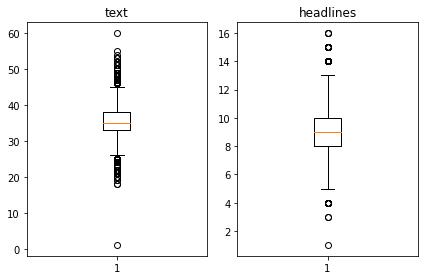

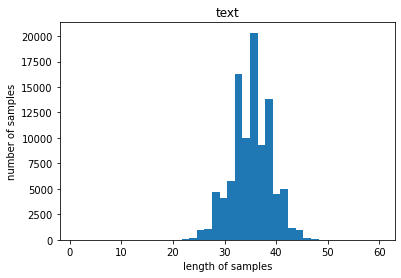

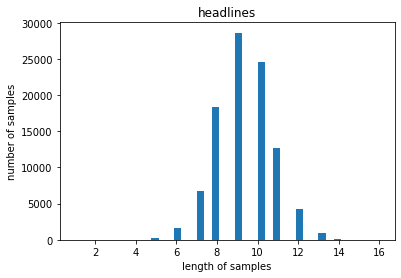

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

🎀 text: 문장길이 42 이후로 금격히 감소해 45부터는 거의 없으므로 max_len을 45로 지정.  
🎀 headlines의 경우 13으로 지정하려고 하였으나 12와 큰 차이가 없어보여 12로 지정

In [18]:
text_max_len = 45
headlines_max_len = 12

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


#### - 시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23185 62352  8264 ... 43324 82848 30262]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


#### - 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69091
등장 빈도가 6번 이하인 희귀 단어의 수: 47143
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21948
단어 집합에서 희귀 단어의 비율: 68.2331996931583
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.522717739573506


In [30]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[351, 7932, 939, 16, 1258, 2289, 57, 1, 589, 5832, 1192, 419, 8778, 8336, 4, 293, 164, 293, 841, 8337, 841, 135, 2289, 69, 1192, 841, 8337, 1536], [152, 15, 116, 48, 86, 376, 36, 91, 1994, 2000, 17308, 147, 5833, 1202, 656, 59, 1571, 3366, 2020, 12102, 257, 10, 332, 7693, 10, 275, 1213, 1612, 233, 2290, 4], [20, 143, 581, 3248, 3628, 3934, 1385, 5938, 48, 120, 3831, 1818, 86, 1534, 20, 143, 14193, 3, 13, 291, 3466, 734, 3, 13, 11, 526, 3248, 1090, 633, 5076, 613, 239, 3]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29958
등장 빈도가 5번 이하인 희귀 단어의 수: 19604
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10354
단어 집합에서 희귀 단어의 비율: 65.4382802590293
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.708774631549016


In [34]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 225, 73, 884, 450, 5, 5142, 3976, 86], [1, 3875, 3, 1011, 22, 39, 7, 981, 470], [1, 1588, 2809, 164, 1712, 12, 39, 1124], [1, 20, 2869, 3, 21, 120, 4, 5612, 648, 94, 1433], [1, 76, 43, 481, 1295, 155, 5, 727, 547, 7, 49]]
target
decoder  [[225, 73, 884, 450, 5, 5142, 3976, 86, 2], [3875, 3, 1011, 22, 39, 7, 981, 470, 2], [1588, 2809, 164, 1712, 12, 39, 1124, 2], [20, 2869, 3, 21, 120, 4, 5612, 648, 94, 1433, 2], [76, 43, 481, 1295, 155, 5, 727, 547, 7, 49, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77496
훈련 레이블의 개수 : 77496
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


In [36]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
어텐션 메커니즘을 사용한 seq2seq 설계

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### - 어텐션 메커니즘 불러오기

In [44]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

#### - 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 204s 643ms/step - loss: 5.4361 - val_loss: 5.0012
Epoch 2/50
303/303 [==============================] - 193s 637ms/step - loss: 4.8523 - val_loss: 4.6241
Epoch 3/50
303/303 [==============================] - 193s 635ms/step - loss: 4.5345 - val_loss: 4.3832
Epoch 4/50
303/303 [==============================] - 192s 634ms/step - loss: 4.2799 - val_loss: 4.1904
Epoch 5/50
303/303 [==============================] - 190s 626ms/step - loss: 4.0757 - val_loss: 4.0427
Epoch 6/50
192/303 [==================>...........] - ETA: 1:06 - loss: 3.9110

In [ ]:
#  훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


#### - 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(3):
    print(i+1, "-------------------------------------------------------")
    print("원문 :", seq2text(encoder_input_test[i]))
    print("\n")
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

## Step 5. Summa의  summarize를  이용해서 추출적 요약해보기
추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text= pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text["text"][0]

In [ ]:
for i in range(3):
    print(i+1, "-------------------------------------------------------")
    print("원문 :", data['text'][i])
    print("\n")
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약 :", summarize(text["text"][i], ratio=0.5))
    print("\n")

## 🥁🥁🥁 비교
1. 추상적 요약보다 추출적 요약이 오히려 더 잘된 것 같은 결과가 나왔다.


2. 추상적 요약이 더 제대로 기능하기 위해서는 더 많은 데이터와 학습이 필요하다.  
     입력 어텐션의 어느 부분에 집중할지 매시점마다 예측하기 때문에 문법완성도가 떨어진다
     

3. 추출적 요약이 문법적으로나 내용적으로 상대적으로 잘 요약된 이유는 문장의 키워드가 되는 단어를 그대로 사용했기 때문이다.  
     단, 추출적 요약시 원문에는 없는 대문자가 나오는 경우가 있었다. `---> 왜인지 확인 필요`
     

4. 추출적 요약에서 추출 요약 결과로 첫 문장을 가져다 주는 경우가 많았다.

## 🥁🥁🥁 회고

- 뒤로 갈수록 노드가 밀리다보니 조금 급하게 해야하는 경우가 많이 생겨서 초반처럼 하나하나 깊이 있게 파고들지 못하고, 노드에 제시해준 것만 구현해내는 수준이라 아쉬움이 남는다... `주말에 시간 내서 다시 봐야지.. 진짜` 
- 추상적 요약, 추출적 요약 이렇게 두가지로 요약봇을 구현해보니 각각 어떤 장점이 있는지 확실하게 알 수 있어서 좋았다.
- 단어장의 크기를 줄이는 다양한 text normalization과 전처리 방법을 적용하며 배울 수 있었던 점이 좋았다.
- 요약문의 크기 조정시 단어수와 비율 모두 지정된 숫자보다 핵심 문장의 단어수/비율이 적으면 좋은 결과를 출력해내지 않으므로 text와 headlines의 maxlen을 알맞게 산정하는 것이 중요하다는 것을 느꼈따. 
- seq2seq의 성능을 Up시키는 Attention Mechanism에 대해 좀 더 조사해보고 블로그에 정리해야겠다 !! 